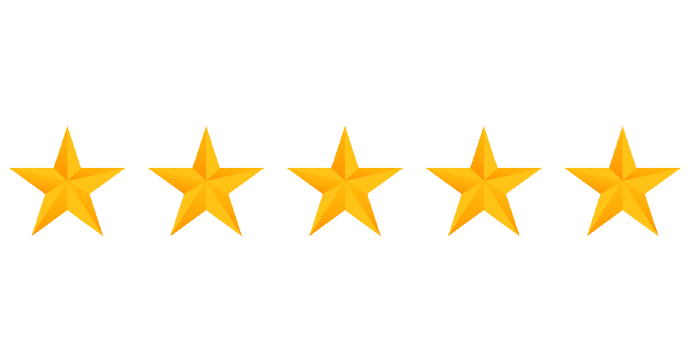

# I- Predict Rate

# 0. Import & Download libraries

In [1]:
# !pip install plotly-express

In [2]:
# !pip install cudf-cu11 --extra-index-url=https://pypi.nvidia.com

In [3]:
# %load_ext cudf.pandas

In [4]:
# pip install cudf-cu11==<version_number> --extra-index-url=https://pypi.nvidia.com

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import nltk
import string
import re
import seaborn as sns
import tensorflow as tf

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import RepeatVector


In [2]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Connect to database

In [3]:
## Connect to database
conn = psycopg2.connect(
    dbname="Claim",
    user="postgres",
    password="root",
    host="localhost",
    port="5432"
)

query = """
    SELECT "Review", "Rating_Before"
    FROM "FACT_Review"
"""

dataset = pd.read_sql(query, conn)

#close the database connection
conn.close()
dataset.head()

C:\Users\HP\AppData\Local\Temp\ipykernel_16240\2005930128.py:15: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  dataset = pd.read_sql(query, conn)


,Review,Rating_Before
0,ok nothing special charge diamond member hilto...,2
1,nice rooms not 4 experience hotel monaco seatt...,3
2,unique great stay wonderful time hotel monac...,5
3,great stay great stay went seahawk game aweso...,5
4,love monaco staff husband stayed hotel crazy w...,5


# 2. Cleaning data

In [4]:
#1. Common text preprocessing
test = "Testing a             TEST...*$$$<+ with @ good 1000 test,  ####  let'S go !"

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(test):
    test = test.lower() #lowercase text
    test=test.strip()  #get rid of leading/trailing whitespace
    test = re.sub('\s+', ' ', test)  #Remove extra space and tabs
    test=re.compile('<.*?>').sub('', test) #Remove HTML tags/markups
    test = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', test)  #Replace punctuation with space
    test=re.sub(r'[^\w\s]', '', str(test).lower().strip())
    test = re.sub(r'\s+',' ',test) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace
    return test

test=preprocess(test)
print(test)

testing a test with good 1000 test let s go


In [5]:
#1. STOPWORD 
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

test=stopword(test)
print("1. Stopwords : ", test)

#2. STEMMING

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

test=stemming(test)
print("2. Stemming : ", test)

#3. LEMMATIZATION
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

test = lemmatizer(test)
print("3. Lemmatization : ", test)

1. Stopwords :  testing test good 1000 test let go
2. Stemming :  test test good 1000 test let go
3. Lemmatization :  test test good 1000 test let go


In [6]:
def finalpreprocess(string):
    return lemmatizer(stemming(stopword(preprocess(string))))

In [7]:
import pandas as pd

# Assuming 'dataset' is your original DataFrame
Claim = pd.DataFrame({'Review': dataset['Review'], 'Rating': dataset['Rating_Before']})
Claim.head()

,Review,Rating
0,ok nothing special charge diamond member hilto...,2
1,nice rooms not 4 experience hotel monaco seatt...,3
2,unique great stay wonderful time hotel monac...,5
3,great stay great stay went seahawk game aweso...,5
4,love monaco staff husband stayed hotel crazy w...,5


In [8]:
# After printing the result of the must used words for each rating, we found out that some words should be cleaned
W_remove = ['rooms', 'staff', 'night', 'hotel','room', 'just', 'service', 'location', 'day','beach', 'told']

# Iterate over each word and remove it from the "Review" column
for word in W_remove:
    Claim['Review'] = Claim['Review'].str.replace(word, '')

# 3. Graphs

In [9]:
# Descriptive statistics
claim_stats = Claim.groupby('Rating')['Rating'].count()

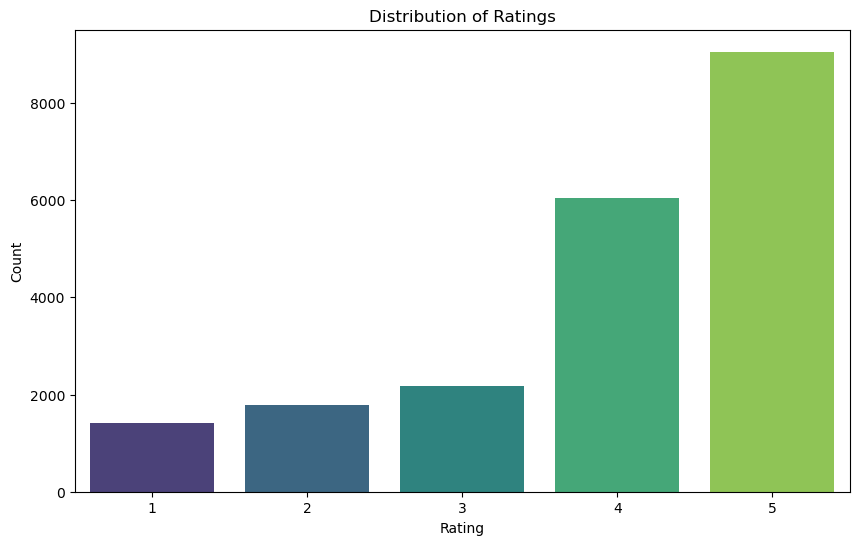

In [10]:
# Bar plot of ratings distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=claim_stats.index, y=claim_stats.values, palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [11]:
# Assuming 'Claim' is the name of your DataFrame
# Assuming 'Claim' is the name of your DataFrame
Claim.loc[Claim['Rating'] == 5, 'Review'] = Claim.loc[Claim['Rating'] == 5, 'Review'] + ' amazing amazing amazing'

In [12]:
Claim.loc[Claim['Rating'] == 5, 'Review'] = Claim.loc[Claim['Rating'] == 5, 'Review'].str.replace('not', 'love') 

In [13]:
# Function to remove specific words from a string
def remove_words(text):
    words_to_remove = ['stay', 'time']
    return ' '.join(word for word in text.split() if word.lower() not in words_to_remove)

# Applying the function to the 'Review' column
Claim['Review'] = Claim['Review'].apply(remove_words)

def remove_n_words(text):
    words = text.split()
    return ' '.join(word for word in words if not re.match(r'^[nN]+$', word))

# Filtering rows with Rating = 5 and applying word removal function
Claim.loc[Claim['Rating'] == 5, 'Review'] = Claim[Claim['Rating'] == 5]['Review'].apply(remove_n_words)

In [14]:
# Tokenize Reviews and calculate word frequency
fdist = FreqDist()

for index, row in Claim.iterrows():
    tokens = word_tokenize(row['Review'])
    fdist.update(tokens)

# Get most common words for each rating
top_words_by_rating = {}

for rating in range(1, 6):
    reviews = Claim[Claim['Rating'] == rating]['Review']
    fdist_rating = FreqDist()
    
    for review in reviews:
        tokens = word_tokenize(review)
        fdist_rating.update(tokens)
    
    top_words_by_rating[f'Rating {rating}'] = fdist_rating.most_common(10)

# Display top words for each rating
for rating, top_words in top_words_by_rating.items():
    print(f"Top words for {rating}:")
    print(top_words)
    print()

Top words for Rating 1:
[('not', 3783), ("n't", 1674), ('no', 1574), ('did', 1313), ('s', 1004), ('like', 713), ('desk', 637), ('place', 636), ('got', 629), ('resort', 620)]

Top words for Rating 2:
[('not', 5216), ("n't", 2359), ('no', 1981), ('did', 1827), ('good', 1490), ('s', 1356), ('food', 1078), ('nice', 1051), ('like', 1001), ('resort', 984)]

Top words for Rating 3:
[('not', 4741), ("n't", 2589), ('good', 2458), ('did', 1929), ('great', 1755), ('nice', 1746), ('no', 1653), ('s', 1414), ('food', 1161), ('clean', 1153)]

Top words for Rating 4:
[('not', 8835), ('great', 7437), ('good', 6714), ("n't", 5956), ('nice', 4827), ('did', 4499), ('s', 3672), ('clean', 3464), ('no', 3137), ('breakfast', 3071)]

Top words for Rating 5:
[('amazing', 28521), ('great', 10688), ('love', 9589), ("n't", 6410), ('good', 5719), ('s', 5292), ('stayed', 4817), ('nice', 4418), ('did', 4329), ('breakfast', 4150)]



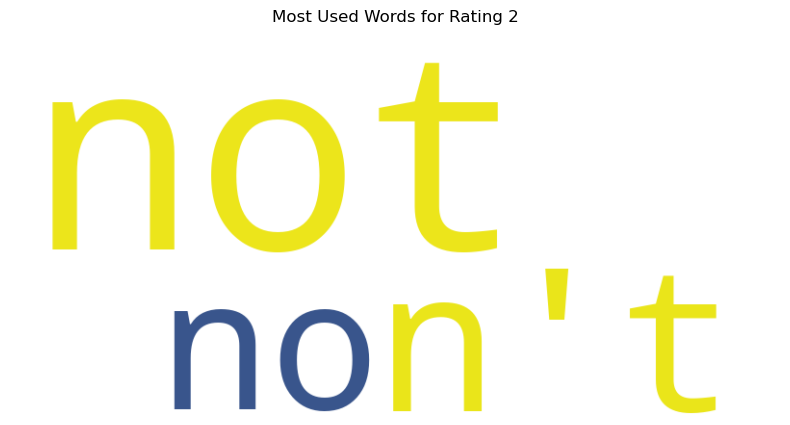

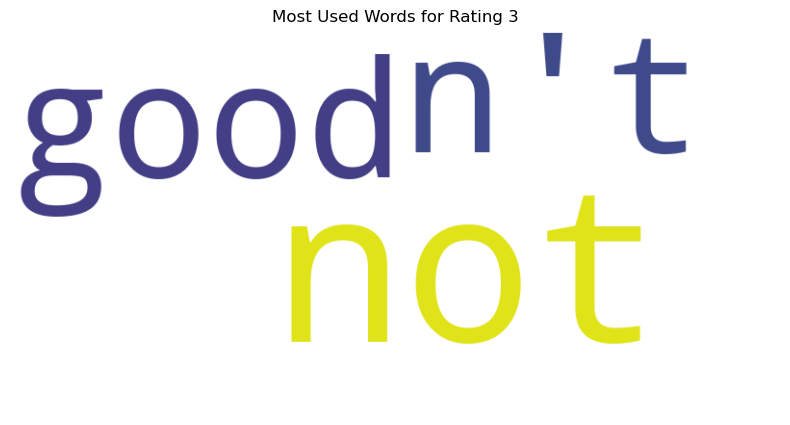

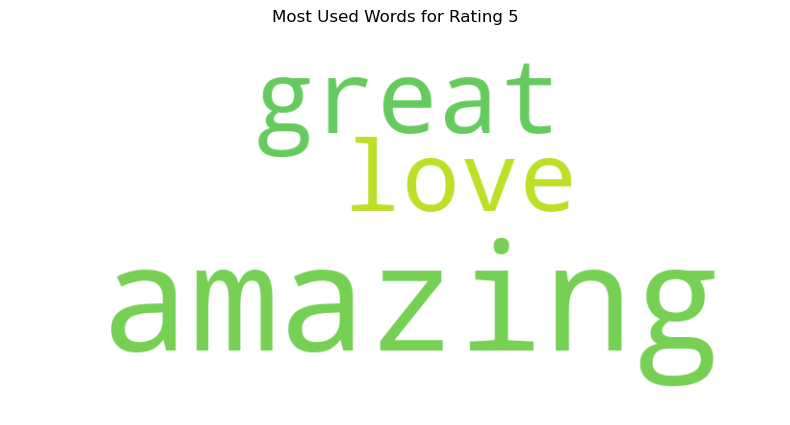

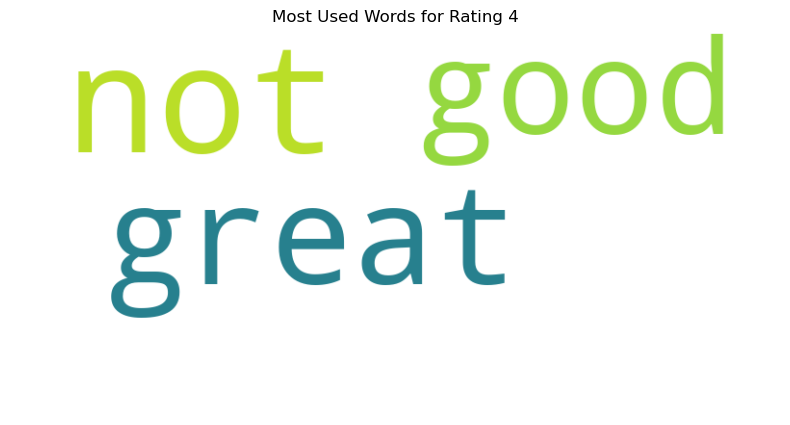

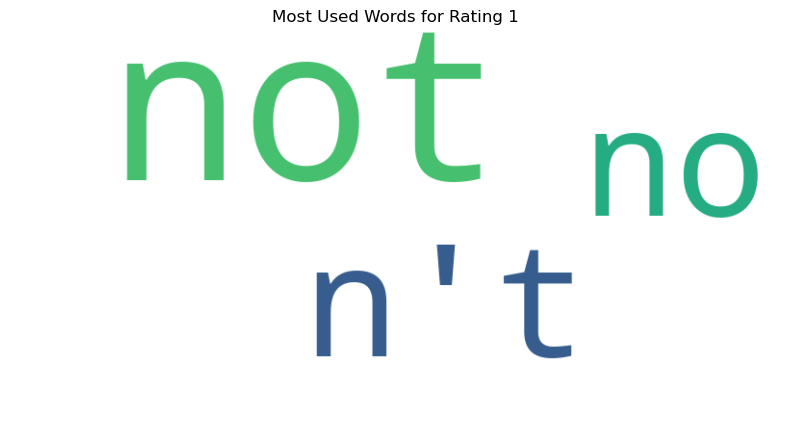

In [15]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing "Reviews" and "Rating_Before" columns

# Define a function to get the most common words
def get_top_words(reviews):
    tokens = word_tokenize(reviews.lower())
    fdist = FreqDist(tokens)
    return fdist.most_common(3)

# Create a dictionary to store the top words for each rating
top_words_dict = {}

# Iterate over unique ratings
for rating in Claim['Rating'].unique():
    reviews_for_rating = ' '.join(Claim[Claim['Rating'] == rating]['Review'])
    top_words = get_top_words(reviews_for_rating)
    top_words_dict[rating] = top_words

# Generate word clouds for each rating
for rating, top_words in top_words_dict.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Most Used Words for Rating {rating}')
    plt.axis('off')
    plt.show()


# 4. Creating a model

In [16]:
Claim['Review']=Claim['Review'].astype(str)
Claim['Review'] = Claim['Review'].apply(lambda x: finalpreprocess(x))

In [17]:
Claim.head()

,Review,Rating
0,ok noth special charg diamond member hilton de...,2
1,nice 4 experi monaco seattl good n 4 level pos...,3
2,uniqu great wonder monaco excel short stroll m...,5
3,great great go seahawk game awesom downfal vie...,5
4,love monaco husband stay crazi weekend attend ...,5


In [18]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Claim['Review'])

x = tokenizer.texts_to_sequences(Claim['Review'])
x = pad_sequences(x, maxlen=100)

In [19]:
y= Claim['Rating']
print("New value of x : ", x)
print("New value of y : ", y)

New value of x :  [[  77  224   91 ...   92  781  542]
 [ 169  934  322 ...   49 1502   20]
 [   0    0    0 ...    1    1    1]
 ...
 [   0    0    0 ...  382  897  768]
 [  19 1065 2865 ...  331 2739 2050]
 [   0    0    0 ...   37  122   12]]
New value of y :  0        2
1        3
2        5
3        5
4        5
        ..
20485    5
20486    4
20487    2
20488    1
20489    2
Name: Rating, Length: 20490, dtype: int64


In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.95:                 
            print("\nReached 95% accuracy so cancelling training!")
            self.model.stop_training = True

In [21]:
# ## After error for model.fit (cannot cast string to float) :
# tokenizer = Tokenizer(num_words=5000)
# tokenizer.fit_on_texts(x_train)

# x_train_seq = tokenizer.texts_to_sequences(x_train)
# x_test_seq = tokenizer.texts_to_sequences(x_test)

# max_sequence_length = 100  # Adjust as needed
# x_train_seq = pad_sequences(x_train_seq, maxlen=max_sequence_length)
# x_test_seq = pad_sequences(x_test_seq, maxlen=max_sequence_length)

# # Example for categorical_crossentropy loss
# y_train_encoded = tf.keras.utils.to_categorical(y_train, num_classes=7)
# y_test_encoded = tf.keras.utils.to_categorical(y_test, num_classes=7)

#--------------------------------------------------------------------------------------------

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Claim['Review'])
x = tokenizer.texts_to_sequences(Claim['Review'])
x = pad_sequences(x, maxlen=100)
y= Claim['Rating']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(Claim['Review'], y, test_size=0.2, random_state=42)

In [23]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [24]:
callbacks = myCallback()

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x, y, epochs=10, batch_size=64, callbacks=[callbacks])

Epoch 1/10
321/321 [==============================] - 66s 186ms/step - loss: 0.6314 - accuracy: 0.7546
Epoch 2/10
321/321 [==============================] - 65s 202ms/step - loss: 0.4340 - accuracy: 0.8166
Epoch 3/10
321/321 [==============================] - 64s 201ms/step - loss: 0.3731 - accuracy: 0.8455
Epoch 4/10
321/321 [==============================] - 67s 207ms/step - loss: 0.3212 - accuracy: 0.8710
Epoch 5/10
321/321 [==============================] - 65s 204ms/step - loss: 0.2693 - accuracy: 0.8928
Epoch 6/10
321/321 [==============================] - 73s 228ms/step - loss: 0.2307 - accuracy: 0.9120
Epoch 7/10
321/321 [==============================] - 67s 209ms/step - loss: 0.1936 - accuracy: 0.9275
Epoch 8/10
321/321 [==============================] - 67s 210ms/step - loss: 0.1575 - accuracy: 0.9439
Epoch 9/10
321/321 [==============================] - ETA: 0s - loss: 0.1189 - accuracy: 0.9597
Reached 95% accuracy so cancelling training!
321/321 [==========================

In [27]:
user_input = input("Your test :")
# Convert the user input to a sequence of word indices using the tokenizer
user_input_sequence = tokenizer.texts_to_sequences([user_input])

# Pad the sequence to a fixed length (assuming maxlen=100 as in the previous example)
user_input_padded = pad_sequences(user_input_sequence, maxlen=100)

# Predict the rating for the user input
predicted_rating = model.predict(user_input_padded)
predicted_rating = np.argmax(predicted_rating) 
print(f"Predicted Rating: {predicted_rating}")

Your test :I love the personal treatement
1/1 [==============================] - 1s 880ms/step
Predicted Rating: 5


In [28]:
user_input = input("Your test :")
# Convert the user input to a sequence of word indices using the tokenizer
user_input_sequence = tokenizer.texts_to_sequences([user_input])

# Pad the sequence to a fixed length (assuming maxlen=100 as in the previous example)
user_input_padded = pad_sequences(user_input_sequence, maxlen=100)

# Predict the rating for the user input
predicted_rating = model.predict(user_input_padded)
predicted_rating = np.argmax(predicted_rating) 
print(f"Predicted Rating: {predicted_rating}")

Your test :the food was bad and cold, i hate it
1/1 [==============================] - 0s 36ms/step
Predicted Rating: 1


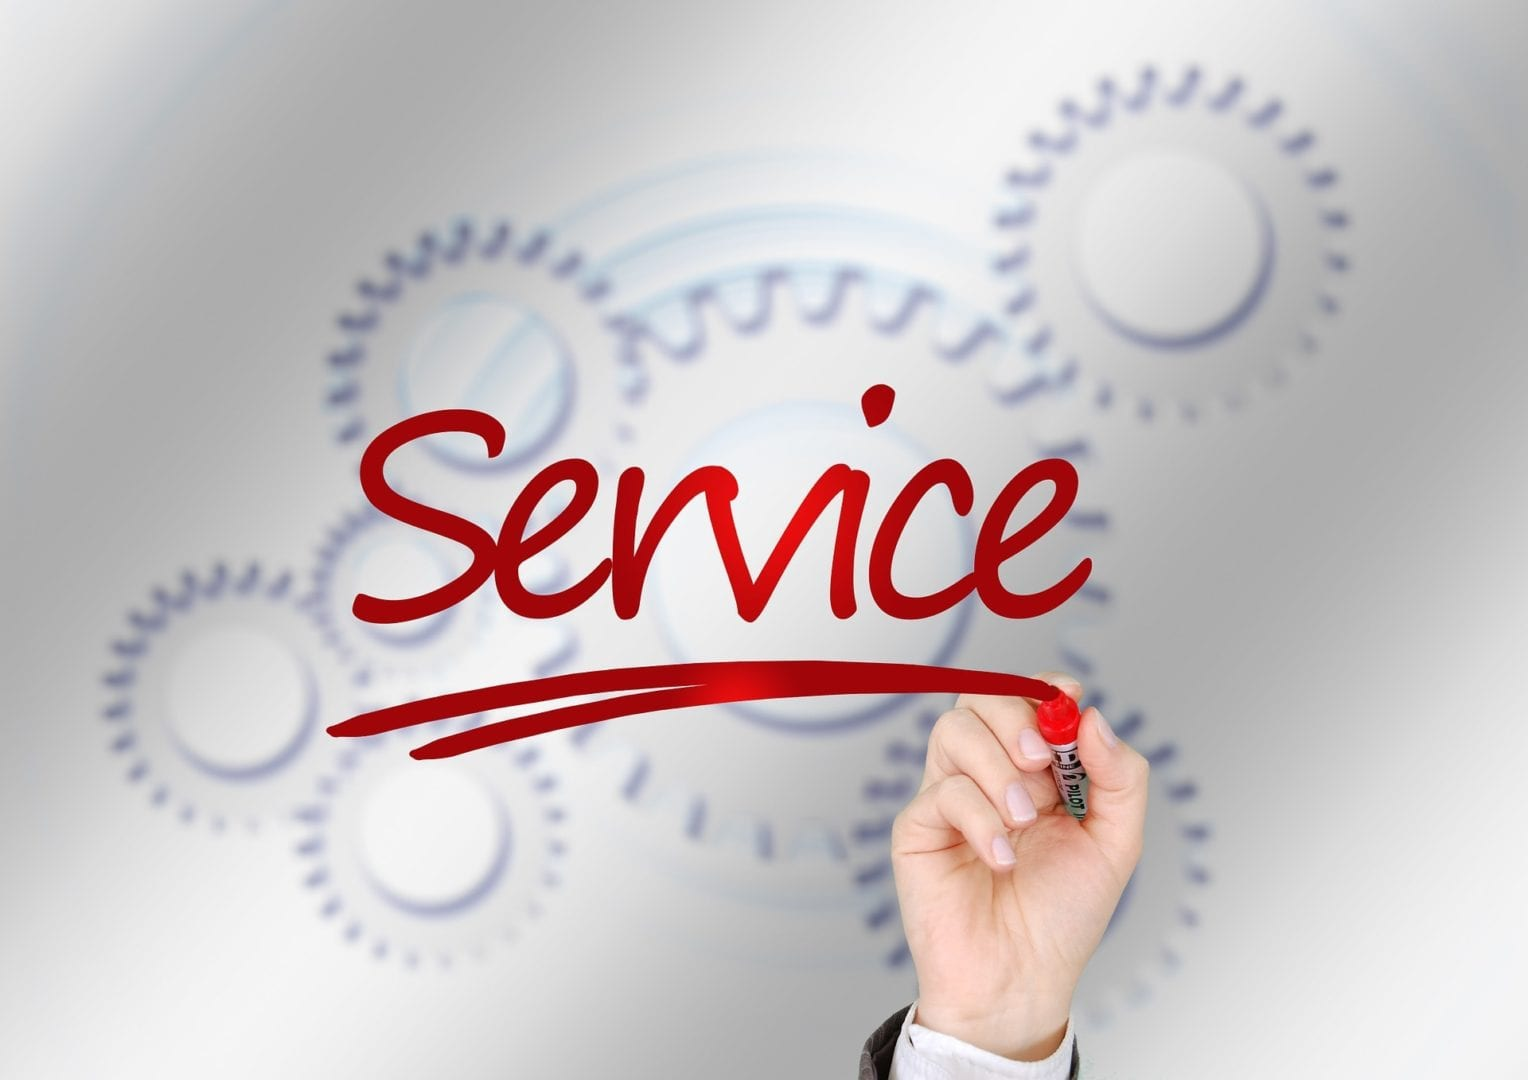

# II- Predict service

### Accomodation & rooms, Animation & Leisure, Atmosphere, Convenience, Custom Care, decoration, food & beverage, hygien, menu, Price, products & assortement, reception, reservation, security, signalization, staff, waiting time.


In [ ]:
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import nltk
import string
import re
import seaborn as sns
import tensorflow as tf

from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional, GRU, SpatialDropout1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import RepeatVector

In [ ]:
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

In [ ]:
## Connect to database
conn = psycopg2.connect(
    dbname="Claim",
    user="postgres",
    password="root",
    host="localhost",
    port="5432"
)

query = """
    SELECT *
    FROM "FACT_Review"
"""

dataset = pd.read_sql(query, conn)

#close the database connection
conn.close()
dataset.head()

In [ ]:
Table = dataset[['Review', 'Service']].copy()
Table.head()

In [ ]:
#0. PREPROCESS
test= "Testing      0.123   tester testing   stemming+%%%*,//###  going to be n" 
print (test)
def preprocess(test):
    test = test.lower() #lowercase text
    test=test.strip()  #get rid of leading/trailing whitespace
    test = re.sub('\s+', ' ', test)  #Remove extra space and tabs
    test=re.compile('<.*?>').sub('', test) #Remove HTML tags/markups
    test = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', test)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    test=re.sub(r'[^\w\s]', '', str(test).lower().strip())
    test = re.sub(r'\s+',' ',test) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace
    return test

#1. STOPWORD 
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

#2. STEMMING

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

#3. LEMMATIZATION
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

def finalpreprocess(string):
    return lemmatizer(stemming(stopword(preprocess(string))))

finalpreprocess(test)

In [ ]:
claim_stats = Table['Service'].value_counts(normalize=True)
filtered_claim_stats = claim_stats[claim_stats > 0.01]

plt.figure(figsize=(8, 8))
plt.pie(filtered_claim_stats.values, labels=filtered_claim_stats.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of services (>1%)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
Table['Review']=Table['Review'].astype(str)

In [ ]:
Table['Review']= Table.Review.apply(lambda Review: finalpreprocess(Review))
Table.head()

In [ ]:
from collections import Counter

# Define a function to get the top N words
def get_top_words(text, n=5):
    words = text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return top_words

# Group reviews by service and find the top 5 words for each service
top_words_dict = {}
services = Table['Service'].unique()

for service in services:
    reviews = " ".join(Table[Table['Service'] == service]['Review'])
    top_words = get_top_words(reviews)
    top_words_dict[service] = top_words

# Display top 5 words for each service
for service, top_words in top_words_dict.items():
    print(f"Service: {service}")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

In [ ]:
from collections import Counter

# Define a function to get the top N words
def get_top_words(text, n=5):
    words = text.split()
    word_counts = Counter(words)
    top_words = word_counts.most_common(n)
    return top_words

# Group reviews by service and find the top 5 words for each service
top_words_dict = {}
services = Table['Service'].unique()

for service in services:
    reviews = " ".join(Table[Table['Service'] == service]['Review'])
    top_words = get_top_words(reviews)
    top_words_dict[service] = top_words

# Display top 5 words for each service
for service, top_words in top_words_dict.items():
    print(f"Service: {service}")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Table['Review'])

x = tokenizer.texts_to_sequences(Table['Review'])
x = pad_sequences(x, maxlen=100)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Fit the LabelEncoder on the 'Service' column
Table['Service_Num'] = label_encoder.fit_transform(Table['Service'])

# Display the unique numerical representations for each service
service_mapping_dynamic = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(service_mapping_dynamic)

In [ ]:
# Convert the dictionary to a DataFrame
service_mapping_df = pd.DataFrame(list(service_mapping_dynamic.items()), columns=['Service', 'Service_Num'])

# Display the DataFrame
print(service_mapping_df)

In [ ]:
Table.drop('Service', axis=1, inplace=True)
Table.head()

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') is not None and logs.get('accuracy') > 0.97:                 
            print("\nReached 97% accuracy so cancelling training!")
            self.model.stop_training = True

In [ ]:
y= Table['Service_Num']
Table.head()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Table['Review'], y, test_size=0.2, random_state=42)
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

In [ ]:
callbacks = myCallback()

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.fit(x, y, epochs=10, batch_size=64, callbacks=[callbacks]) 

In [ ]:
service_mapping_df = pd.DataFrame(list(service_mapping_dynamic.items()), columns=['Service', 'Service_Num'])
service_mapping_df

In [ ]:
new_review = "The thing I lked about this place, is that ### thre's cameras everwhere, I feel safe "

sequences = tokenizer.texts_to_sequences([new_review])
# Pad the sequences to the required length
padded_sequences = pad_sequences(sequences, maxlen=100)

# Predict the Service_Num
predicted_probabilities = model.predict(padded_sequences)
predicted_service_num = np.argmax(predicted_probabilities)

print(f"The predicted Service_Num for the review '{new_review}' is: {predicted_service_num}")

##  Option 2 (optional)

In [ ]:
dictionary= {
    'Accommodation and Rooms':['Room', 'Accommodation', 'Suite', 'Bed', 'Bathroom', 'Clean', 'Spacious', 'Comfortable', 'Cozy', 'View', 'Amenities', 'Linens',  'Towels', 'Bedding', 'Stay', 'Lodging', 'Sleeping,', 'Rest','room', 'accommodation', 'lodging', 'suite'],
    'animation / Leisure':['entertainment', 'recreation', 'leisure', 'animation', 'Entertainment,', 'Activities,', 'Fun,', 'Amusement,', 'Recreation,', 'Events,', 'Leisure,' ,'Play,', 'Games,' ,'Performances,' 'Shows,' 'Entertainment,' 'Sports,' 'Leisurely,' ,'Recreation,' ,'Hobbies,' ,'Relaxation,' ,'Enjoyment' ],
    'atmosphere': ['ambiance', 'environment', 'vibe', 'atmosphere', 'Ambiance,', 'Vibe,', 'Mood,' ,'Environment,', 'Aura,' ,'Feeling,' ,'Energy,', 'Surroundings,' ,'Climate,', 'Tone,' ,'Spirit,' ,'Character,' ,'Essence,', 'Vibes,', 'Air,', 'Setting' ],
    'convenience': ['Ease,', 'Comfort,' ,'Accessibility,' ,'Handiness,', ',Suitability,' ,'Facility,', 'Utility,' ,'Advantage,' ,'Amenities,', 'Flexibility,' ,'Effortlessness,' ,'Expediency,', 'Serviceability,', 'Simplicity,' ,'Practicality' ],
    'custom care': ['Personalization,' ,'Tailored' ,'Service,' ,'Individualized' ,'Attention,' ,'Customer', 'Service,' ,'Client' ,'Support,' ,'Care,' ,'Assistance,' ,'Support,' ,'Attention,' ,'Concern,', 'Help,', 'Aid,' ,'Guidance,', 'Service', 'Excellence,' ,'Customer' ,'Satisfaction' ],
    'decoration': ['Decor,', 'Interior' ,'Design,' ,'Furnishing,' ,'Ornaments,', 'Design', 'Elements,' ,'Aesthetics,' ,'Embellishment,', 'Adornment,', 'Style,' ,'Ornamentation,', 'Furnishing,', 'Interior', 'Accents,' ,'Decorative', 'Pieces,', 'Design' ,'Features,', 'Artistry' ],
    'food and beverage': ['Cuisine,', 'Dishes,' ,'Gastronomy,', 'Menu,' ,'Meals,', 'Edibles,' ,'Fare,', 'Foodstuff,' ,'Eats,' ,'Culinary,', 'Delicacies,' ,'Cooking,' ,'Recipes,' ,'Food' ,'Beverage,' ,'Provisions,', 'Nutriment' ],
    'hygiene': ['Cleanliness,' ,'Sanitation,', 'Sterilization,', 'Hygiene,' ,'Healthiness,' ,'Sanitary' ,'Practices,' ,'Disinfection,', 'Purification,' ,'Health' ,'Standards' ],
    'menu': ['Dishes,' ,'Items,' ,'Options,' ,'Selections,' ,'Menus,' ,'Food' ,'Choices,' ,'Offerings,' ,'Courses,' ,'Cuisine,'],
    'price / invoicing': ['Cost,', 'Pricing,' ,'Expense,' ,'Rates,', 'Value,' ,'Charges,' ,'Tariff,', 'Price' ,'Fee,', 'Costliness' ],
    'products / assortment': ['Merchandise,','Items,' ,'Offerings,' ,'Articles,' ,'Wares,' ,'Commodities,', 'Stock,' ,'Inventory' ],
    'reception': ['Reception,', 'Welcome,' ,'Hospitality,' ,'Greeting,', 'Front' 'desk,' ,'Check-in,' ,'Welcome', 'area' , 'check-out'],
    'reservation': ['Reservation,', 'Booking,', 'Appointment,' ,'Scheduled,' ,'Reserved,', 'Booked,', 'Confirmed' ],
    'security': ['Safety,', 'Protection,' ,'Security' ,'Measures,', 'Secure', 'Environment,', 'Guarded,' ,'Surveillance,', 'Safety' ,'Protocols' , 'cameras'],
    'signalization': ['Signs,', 'Signage,' ,'Directional' ,'Signs,', 'Information', 'Boards,', 'Notifications,', 'Alerts' ],
    'staff': ['Attendants,' ,'Employees,' ,'Workers,', 'Personnel,', 'Staff', 'Members' ],
    'waiting time': ['Patience,' ,'Waiting', 'Period,' ,'Waiting' ,'Duration,delay,' ,'interval,', 'holdup,' ,'pause,', 'downtime' ,'time']
}

In [ ]:
#1. Common text preprocessing
test = "Testing a             TEST...*$$$<+ with @ good 1000 test,  ####  let'S go !"

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(test):
    test = test.lower() #lowercase text
    test=test.strip()  #get rid of leading/trailing whitespace
    test = re.sub('\s+', ' ', test)  #Remove extra space and tabs
    test=re.compile('<.*?>').sub('', test) #Remove HTML tags/markups
    test = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', test)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    test=re.sub(r'[^\w\s]', '', str(test).lower().strip())
    test = re.sub(r'\s+',' ',test) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace
    return test

test=preprocess(test)
print(test)

#1. STOPWORD 
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

test=stopword(test)
print("1. Stopwords : ", test)

#2. STEMMING

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

test=stemming(test)
print("2. Stemming : ", test)

#3. LEMMATIZATION
wl = WordNetLemmatizer()

# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)]
    return " ".join(a)

test = lemmatizer(test)
print("3. Lemmatization : ", test)

In [ ]:
Table['Review'] = Table['Review'].apply(lambda x: finalpreprocess(x))

In [ ]:
def compare_with_dictionaries(review, dictionary):
    max_count = 0
    predicted_service = None
    for service, words in dictionary.items():
        count = sum(review.lower().count(word.lower()) for word in words)
        if count > max_count:
            max_count = count
            predicted_service = service
    return predicted_service

In [ ]:
def finalpreprocess(dictionary):
    preprocessed_dict = {}
    for key, words in dictionary.items():
        preprocessed_words = [preprocess(word) for word in words]
        preprocessed_dict[key] = preprocessed_words
    return preprocessed_dict

preprocessed_service_dictionaries = finalpreprocess(dictionary)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Table['Review'], y, test_size=0.2, random_state=42)

In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Tokenize the text data
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

# Pad sequences to a fixed length (e.g., maxlen=100)
maxlen = 100
x_train = pad_sequences(x_train, maxlen=maxlen)
x_test = pad_sequences(x_test, maxlen=maxlen)

y_train = np.array(y_train)
y_test = np.array(y_test)


In [ ]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

In [ ]:
callbacks = myCallback()

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(LSTM(100))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(17, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Predict probabilities for each class using ANN 
probabilities = model.predict(x_test)
predictions_ann = probabilities.argmax(axis=1)

In [ ]:
def compare_with_dictionaries(review, dictionaries):
    predicted_service = None
    max_count = 0
    
    for dictionary in dictionaries:
        for service, words in dictionary.items():
            count = sum(review.lower().count(word.lower()) for word in words)
            
            if count > max_count:
                max_count = count
                predicted_service = service
    
    return predicted_service

# Reshape predictions_ann to a 1D array
predictions_ann = predictions_ann.reshape(-1)

for idx, review in enumerate(x_test):
    # Retrieve the actual review text from the NumPy array
    review_text = review.tolist()  # Or use review.item() if review is a single value array

    # Compare the review with dictionaries
    predicted_service_dict = compare_with_dictionaries(review_text, [dictionary])

    # If ANN model prediction and dictionary-based prediction don't match, display both
    ann_prediction = label_encoder.inverse_transform(predictions_ann[idx])
    if ann_prediction != predicted_service_dict:
        print(f"Review: {review_text}")
        print(f"ANN Prediction: {ann_prediction}")
        print(f"Dictionary Prediction: {predicted_service_dict}")




In [ ]:
print(predictions_ann.shape)
print(predictions_ann[idx].shape)
